<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-model-registry/Ensembles_in_the_W%26B_Model_Registry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Storing Ensemble Models with W&B Model Registry

This colab assumes you are familiar with Artifact, Collections, and the Model registry. Please see https://docs.wandb.ai/guides/models for details on such topics

`ensemble` - noun: "a group of items viewed as a whole rather than individually."

Ensemble Modeling is the class of solutions which have multiple sub-models which comprise a composite "model" of prediction. It is helpful to think of an Ensemble Model as a DAG (Directed Acyclical Graph) of models. A common pattern is to have individual engineers or teams working on different pieces of the composite, especially if each piece is complex. For example,

![dataset_card_overview](https://drive.google.com/uc?export=view&id=1KE5yqjAEZELwEpG81ttPJvoesRwgLCY9)

Now, there are many considersations and challenges with training such models:
- Tracking and versioning training data for child models generated by the parent models
- Evaluating & optimizing sub-components in isolation
- Evaluating & fine tuning the composite ensemble
- Facilitating independent workflows for each piece 

----

In the interest of keeping the code simple and runtimes quick, we will use dummy data, models, and training functions so that the reader can focus on the mechanics / workflow.

In [ ]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 181 kB 44.1 MB/s 
     |████████████████████████████████| 156 kB 45.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
import os
PROJECT = "ensemble_example_dev_3"

In [ ]:
## Dummy Functions:
import random
import json
import wandb

def _dummy_return():
  return {'val': random.random()}

def make_artifact(obj, name, typename, file, run, log=True):
  art = wandb.Artifact(name, typename)
  with art.new_file(file) as file:
    file.write(json.dumps(obj))
  if log:
    run.log_artifact(art)
  return art

def load_obj_from_artifact(run, name, file):
  art = run.use_artifact(name)
  ref = art.get_path(file)
  with open(ref.download(), 'r') as file:
    obj = json.load(file)
  return obj, ref

def generate_data():
  return _dummy_return()

def train_m1(data):
  return _dummy_return()

def m1_predict(m1, data):
  return _dummy_return()

def train_m2(data):
  return _dummy_return()

def m2_predict(m2, data):
  return _dummy_return()

def prepare_m3_data(m1_data, m2_data):
  return _dummy_return()

def train_m3(m3_data):
  return _dummy_return()

def m3_predict(m3, m3_data):
  return _dummy_return()

def make_ensemble_model(m1, m2, m3):
  return _dummy_return()

def ensemble_predict(ensemble, data):
  return _dummy_return()

# Step 0: Create Registered Models
Before we train our models, we will want to create Registered Models for **each of our sub models as well as one for the entire ensemble.** 
- Navigate to the model registry and click "Create Registered Model". 
- Set the entity to the team you want this registered model to be visible to and the project to "model-registry". Do this for:
  - ensemble_m1
  - ensemble_m2
  - ensemble_m3
  - ensemble_all

See screenshots below:
![dataset_card_overview](https://drive.google.com/uc?export=view&id=13VM43j_7iaN8Hxn74yWWrn2nBismdvdU)
![dataset_card_overview](https://drive.google.com/uc?export=view&id=10SmD_JIRN7BdKTg6hHLTeXePi8S1Y3Uh)

# Step 2: Train each piece of the ensemble and link them to the Registry
- This can happen independently. The benefit of the registry is tracking the state of independent workstreams asynchronously.

## Generate Data

In [ ]:
## Run 1: Generate Data:
with wandb.init(project=PROJECT, job_type="generate_data") as run:
  data = generate_data()
  make_artifact(data, "example_data", "dataset", "data.json", run)

## Train M1

In [ ]:
## Run 2: Train M1
with wandb.init(project=PROJECT, job_type="train_m1") as run:
  data, _ = load_obj_from_artifact(run, "example_data:latest", "data.json")
  # Let's train 3 epochs
  for _ in range(3):
    m1 = train_m1(data)
    art = make_artifact(m1, f"m1-{run.id}", "model", "model.json", run)
  # And we will link our last epoch to the m1_collection:
  run.link_artifact(art, "ensemble_m1", ["latest"])

After the above two cells, W&B will have artifacts for both a dataset and a model, and the implicit DAG will begin to grow:

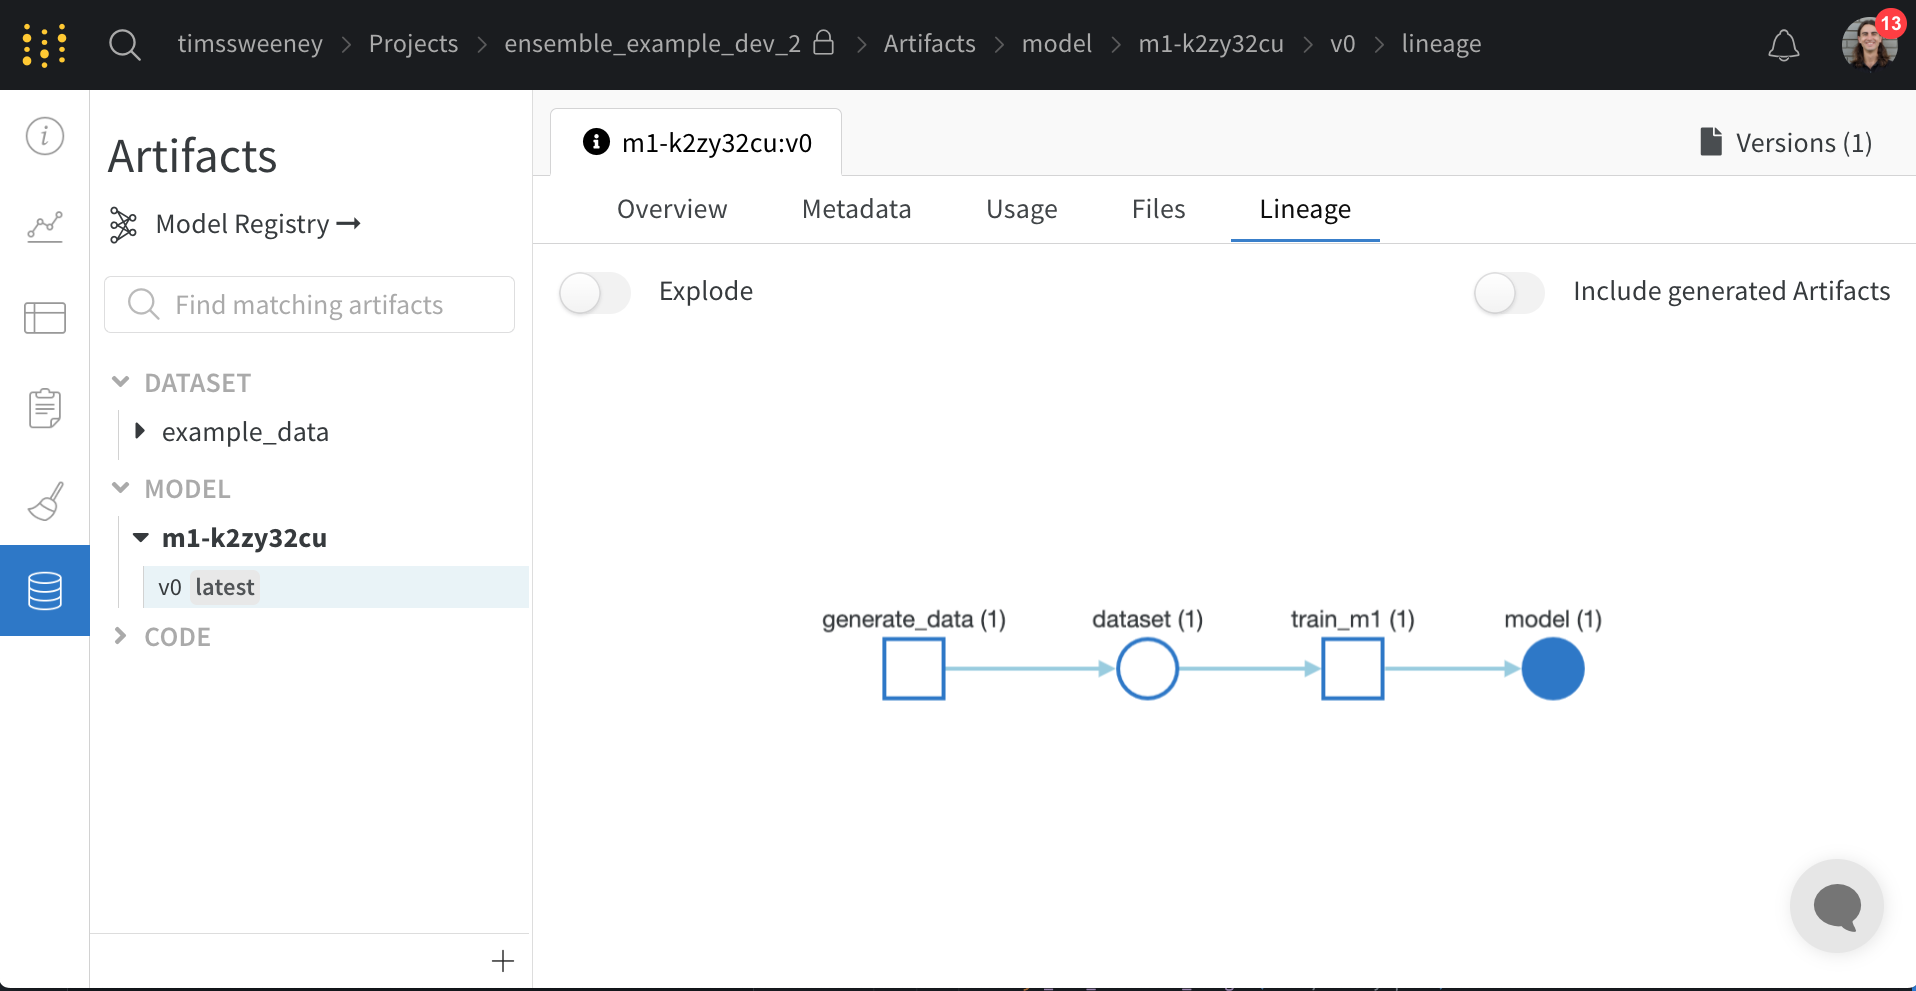

## Train M2

In [ ]:
with wandb.init(project=PROJECT, job_type="train_m2") as run:
  data, _ = load_obj_from_artifact(run, "example_data:latest", "data.json")
  # Let's train 3 epochs
  for _ in range(3):
    m2 = train_m2(data)
    art = make_artifact(m2, f"m2-{run.id}", "model", "model.json", run)
  # And we will link our last epoch to the m2_collection
  run.link_artifact(art, "ensemble_m2", ["latest"])

## Train M3

In [ ]:
## Run 4: Train M3

with wandb.init(project=PROJECT, job_type="train_m3") as run:
  data, _ = load_obj_from_artifact(run, "example_data:latest", "data.json")
  
  # here, we reference the collection
  m1, _ = load_obj_from_artifact(run, "ensemble_m1:latest", "model.json")
  # here, we reference the collection
  m2, _ = load_obj_from_artifact(run, "ensemble_m2:latest", "model.json")

  # let's make the input data for the model (and save it for good measure)
  m3_data = prepare_m3_data(m1_predict(m1, data), m2_predict(m1, data))
  make_artifact(m3_data, "intermedia_m3_data", "dataset", "data.json", run)

  # Let's train 3 epochs
  for _ in range(3):
    m3 = train_m3(m3_data)
    art = make_artifact(m3, f"m3-{run.id}", "model", "model.json", run)
  # And we will link our last epoch to the m3_collection:
  run.link_artifact(art, "ensemble_m3", ["latest"])

# Step 3: Assemble the Ensemble and link to Registry

## Assemble the Ensemble
You can create composite artifacts by adding references to other W&B artifacts into a single artifact. This allows you to create complex dependency structures among model collections. 

`ref = wandb.Artifact.get_path(file)` retrieves an internal reference uri to the W&B artifact. We can pass this reference around to other collections that might be using this model in some way. 

In this example, `load_obj_from_artifact` gives us the model and its W&B reference uri, which we then add to the composite ensemble artifact. 
```
def load_obj_from_artifact(run, name, file):
  art = run.use_artifact(name)
  ref = art.get_path(file)
  with open(ref.download(), 'r') as file:
    obj = json.load(file)
  return obj, ref
```

In [ ]:
## Run 5: Assemble the Ensemble

with wandb.init(project=PROJECT, job_type="ensemble_assembly") as run:
  # here, we reference the collection
  m1, m1_ref = load_obj_from_artifact(run, "ensemble_m1:latest", "model.json")
  # here, we reference the collection
  m2, m2_ref = load_obj_from_artifact(run, "ensemble_m2:latest", "model.json")
  # here, we reference the collection
  m3, m3_ref = load_obj_from_artifact(run, "ensemble_m3:latest", "model.json")

  ensemble = make_ensemble_model(m1, m2, m3)
  art = make_artifact(ensemble, f"all-{run.id}", "model", "model.json", run, False)
  art.add_reference(m1_ref, "m1.model.json")
  art.add_reference(m2_ref, "m2.model.json")
  art.add_reference(m3_ref, "m3.model.json")
  run.log_artifact(art)
  run.link_artifact(art, "ensemble_all", ["latest"]) 

# Accessing Ensemble Pieces
Specific sub models from runs can be accessed with:
  - `run.use("sub_model_collection_name-RUN_ID:ALIAS")`
  
Specific sub models can be accessed with:
  - `run.use("sub_model_collection_name:ALIAS")`

Specific composite ensembles can be accessed with:
  - `run.use("ensemble_name:ALIAS")`

Finally, W&B reflects the underlying structure of your models:

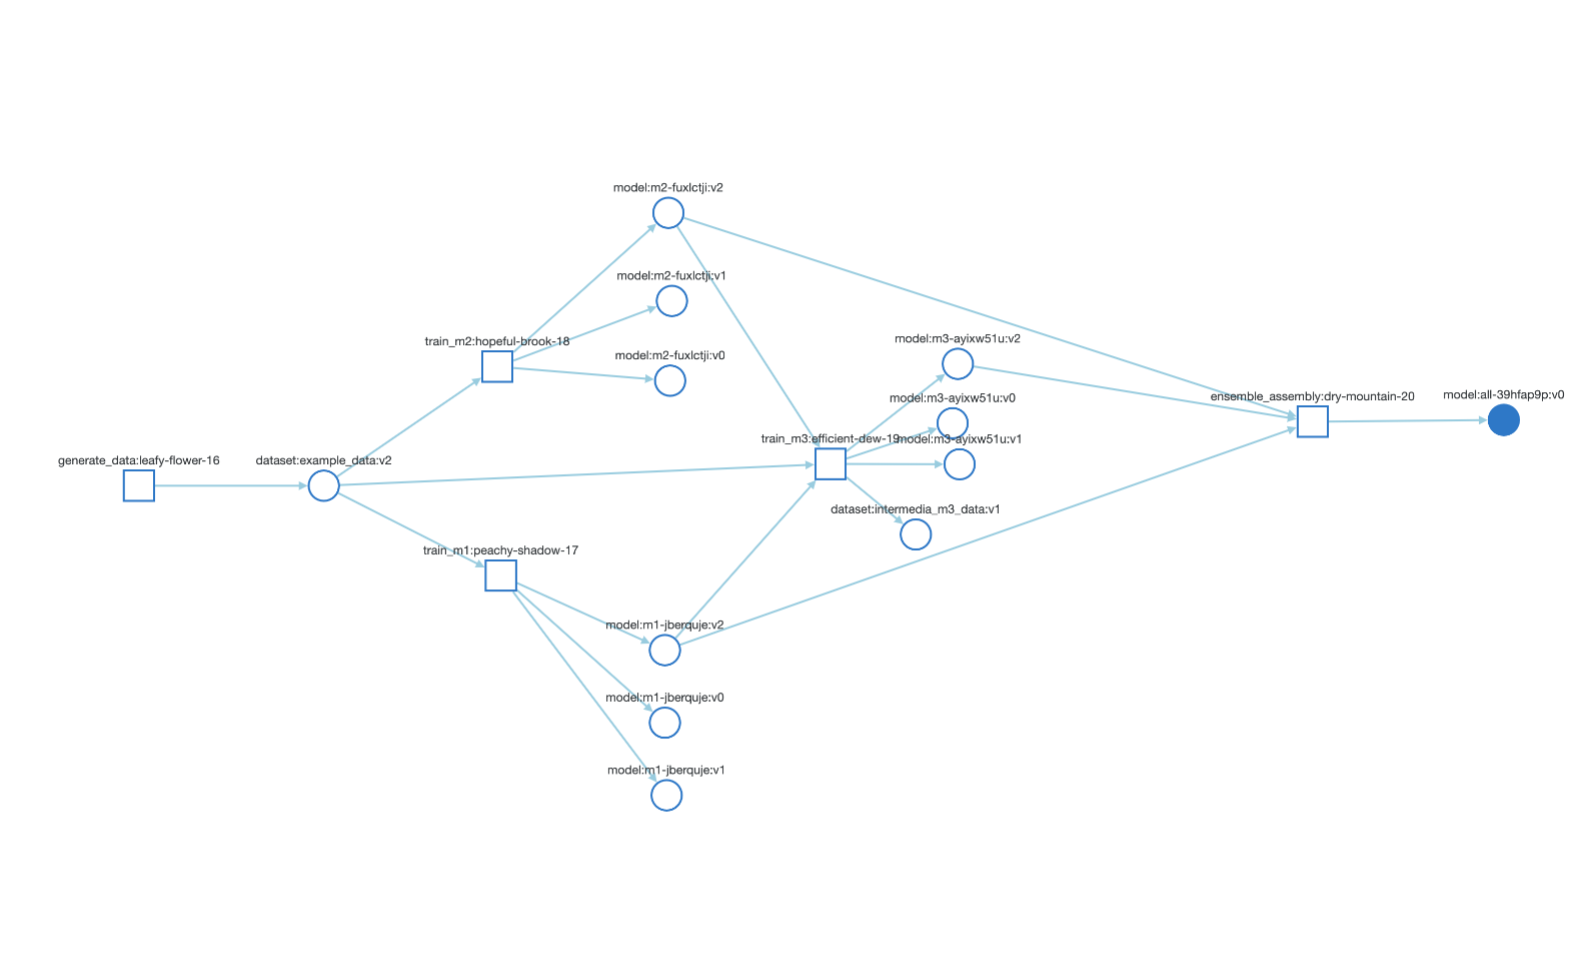